In [52]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [66]:
num_gpus = torch.cuda.device_count()
print("Number of available GPUs:", num_gpus)
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device_index = 0
device = torch.device(f"cuda:{device_index}" if torch.cuda.is_available() and device_index < num_gpus else "cpu")
print("Using device:", device)

Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using device: cuda:0


#### model

In [54]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#### functions

In [55]:
# analytical solution
def exact_solution(x, omega):
    return (1 / omega) * torch.sin(omega * x)


##### total cost function

In [69]:
# residual cost
def residual_loss(model, x, omega):
    u = model(x)
    dudx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0].to(device)
    physics_loss = torch.mean((dudx - torch.cos(omega * x)) ** 2).to(device)
    return physics_loss

# beginning condition cost
def boundary_loss(model):
    u0 = model(torch.tensor([[0.0]], dtype=torch.float32).to(device)).to(device)
    return (u0 ** 2).to(device)

# total cost function
def total_loss(model, x, omega):
    return (residual_loss(model, x, omega) + boundary_loss(model)).to(device)


##### plotting function

In [82]:
def plot_solution(model, x_test, x_train, u_exact, costs, epochs):
    with torch.no_grad():
        
        x_test = x_test.to(device)
        x_train = x_train.to(device)
        
        u_pred = model(x_test)
        
        x_test_cpu = x_test.cpu().numpy()
        u_pred_cpu = u_pred.cpu().numpy()
        u_exact_cpu = u_exact.cpu().numpy()
        x_train_cpu = x_train.cpu().detach().numpy()

        # Solution plot
        plt.figure(figsize=(12, 6))
        plt.plot(x_test_cpu, u_exact_cpu, label='Exact Solution', color='blue')
        plt.plot(x_test_cpu, u_pred_cpu, label='PINN Solution', color='red', linestyle='dashed')
        plt.scatter(x_train_cpu, model(x_train).cpu().detach().numpy(), color='black', s=1)
        plt.title(f'Solution after {epochs} epochs')
        plt.legend()
        plt.show()

        # Error function plot
        plt.figure(figsize=(12, 6))
        plt.plot(x_test_cpu, abs((u_exact_cpu - u_pred_cpu)).reshape(-1, 1), label='Error Function', color='red')
        plt.title('Error Function')
        plt.legend()
        plt.show()

        # Loss function plot
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(epochs), costs, label='Cost Function', color='purple')
        plt.title('Cost function')
        plt.xlabel('Epochs')
        plt.ylabel('Cost function')
        plt.legend()
        plt.show()


#### train

In [58]:
# training function

def train(model, omega, cost_function, epochs, x_train, lr):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    costs = np.empty(epochs)
    
    for _ in range(epochs + 1):
        optimizer.zero_grad()
        loss = cost_function(model, x_train, omega)
        np.append(costs, loss.item())
        loss.backward()
        optimizer.step()
        
    return model, costs

#### constants

In [59]:
N_INPUT = 1
N_OUTPUT = 1
LR = 0.001
EPOCHS = 50000

#### a)

In [68]:
OMEGA = 1.0
N_HIDDEN = 16
N_LAYERS = 2
TRAINING_POINTS = 200
TESTING_POINTS = 1000

x_train_a = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

x_train_a = x_train_a.to(device)

model_a = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

model_a = model_a.to(device)


In [70]:
model_a, costs_a = train(model_a, OMEGA, total_loss, EPOCHS, x_train_a, LR)

model_test_a = model_a

In [62]:
torch.save(model_a, "model_a.pth")

In [63]:
x_test_a = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_a = exact_solution(x_test_a, OMEGA)

In [64]:
model_test_a = torch.load("model_a.pth")

In [83]:
plot_solution(model_test_a, x_test_a, x_train_a, u_exact_a, costs_a, EPOCHS)

TypeError: plot_solution() missing 1 required positional argument: 'device'

#### b)

In [ ]:
OMEGA = 15
TRAINING_POINTS = 3000
TESTING_POINTS = 5000

x_train_b = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

##### 1)

In [ ]:
N_HIDDEN = 16
N_LAYERS = 2

model_b1 = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

In [ ]:
model_b1, costs_b1 = train(model_b1, OMEGA, total_loss, EPOCHS, x_train_b, LR)

model_test_b1 = model_b1

In [ ]:
torch.save(model_b1, "model_b1.pth")

In [ ]:
x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_b1 = exact_solution(x_test_b, OMEGA)

In [ ]:
model_test_b1 = torch.load("model_b1.pth")

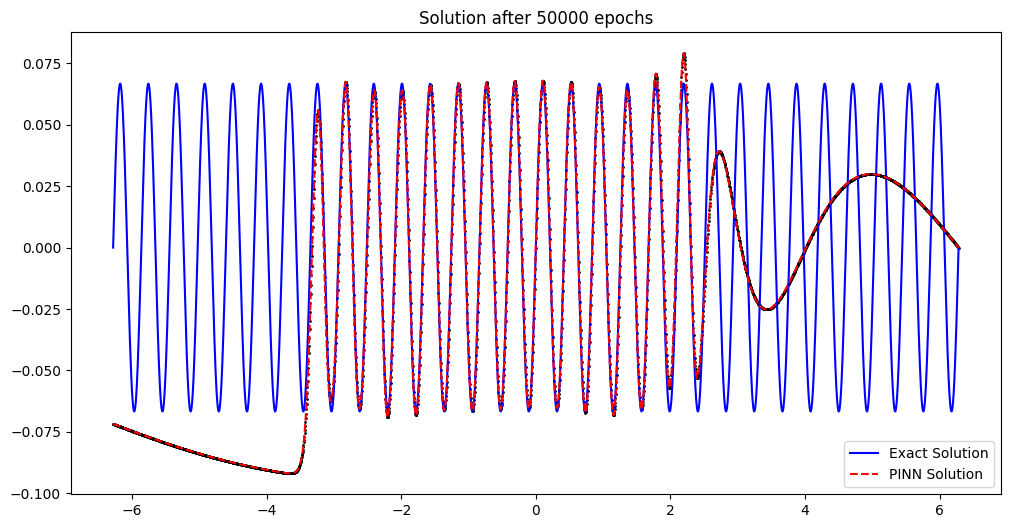

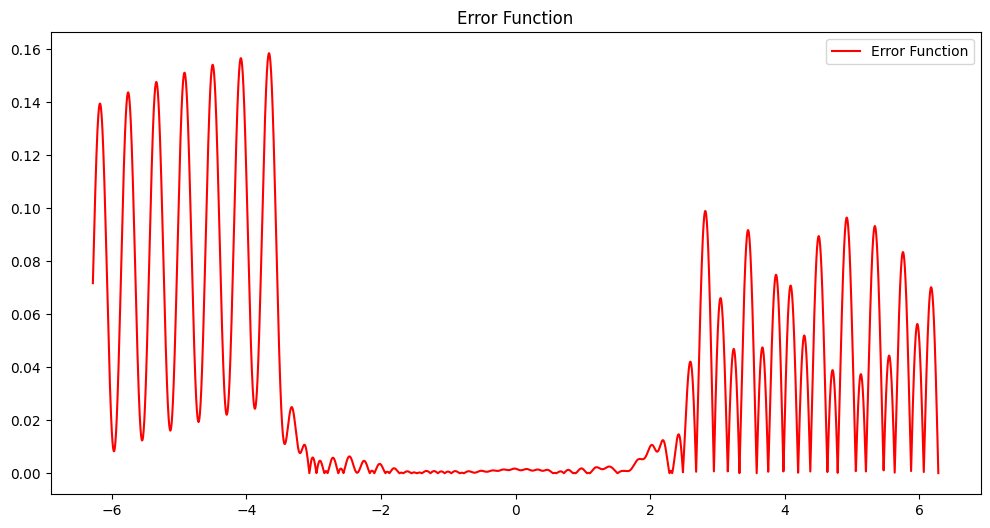

c:\agh\sem4\MOwNiT\.venv\Lib\site-packages\matplotlib\axes\_base.py:2920: RuntimeWarning: overflow encountered in scalar subtract
  delta = (x1t - x0t) * margin


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1200x600 with 1 Axes>

In [ ]:
plot_solution(model_test_b1, x_test_b, x_train_b, u_exact_b1, costs_b1, EPOCHS)

##### 2)

In [ ]:
N_HIDDEN = 64
N_LAYERS = 4

model_b2 = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

In [ ]:
model_b2, costs_b2 = train(model_b2, OMEGA, total_loss, EPOCHS, x_train_b, LR)

model_test_b2 = model_b2

In [ ]:
torch.save(model_b2, "model_b2.pth")

In [ ]:
x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_b2 = exact_solution(x_test_b, OMEGA)

In [ ]:
model_test_b2 = torch.load("model_b2.pth")

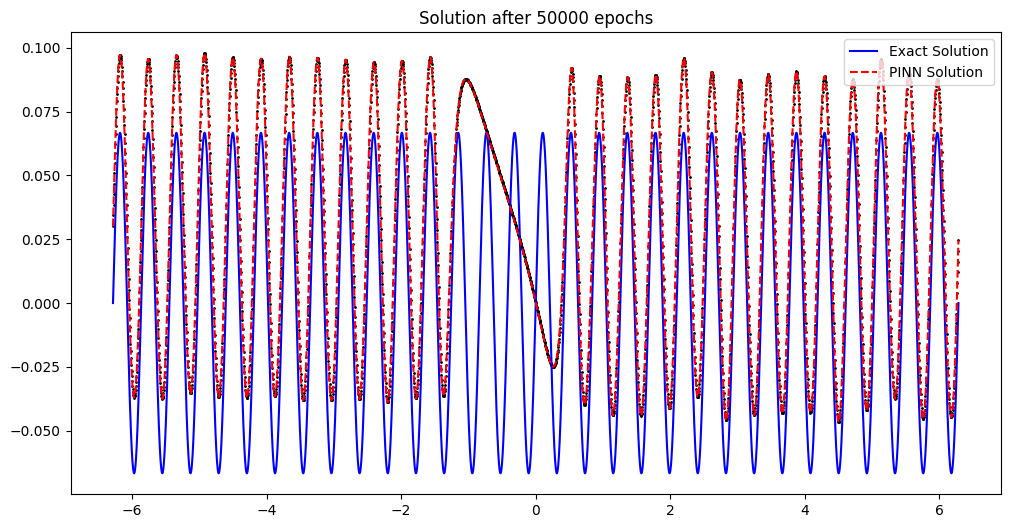

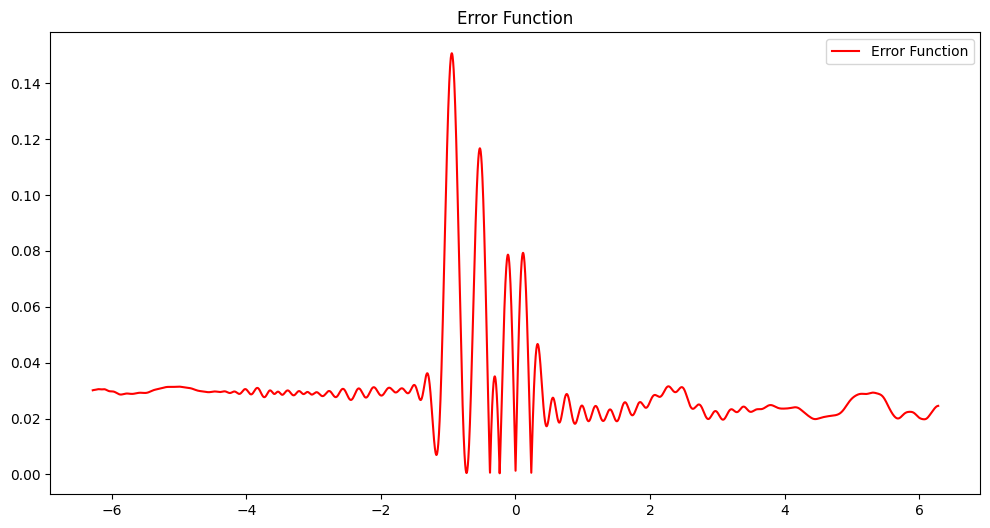

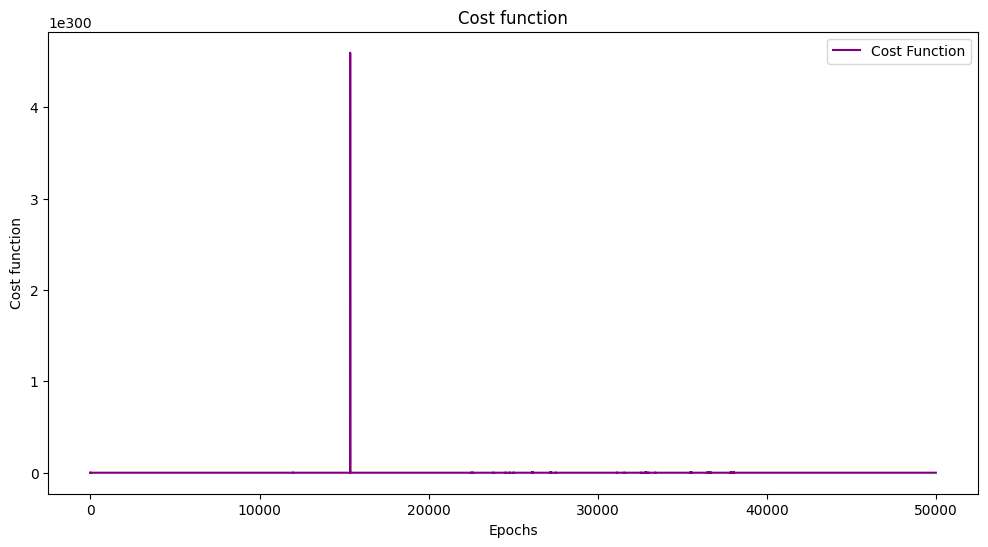

In [ ]:
plot_solution(model_test_b2, x_test_b, x_train_b, u_exact_b2, costs_b2, EPOCHS)

##### 3)

In [ ]:
N_HIDDEN = 128
N_LAYERS = 5

model_b3 = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

In [ ]:
model_b3, costs_b3 = train(model_b3, OMEGA, total_loss, EPOCHS, x_train_b, LR)

model_test_b3 = model_b3

KeyboardInterrupt: 

In [ ]:
torch.save(model_b3, "model_b3.pth")

In [ ]:
x_test_b = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_b3 = exact_solution(x_test_b, OMEGA)

In [ ]:
model_test_b3 = torch.load("model_b3.pth")

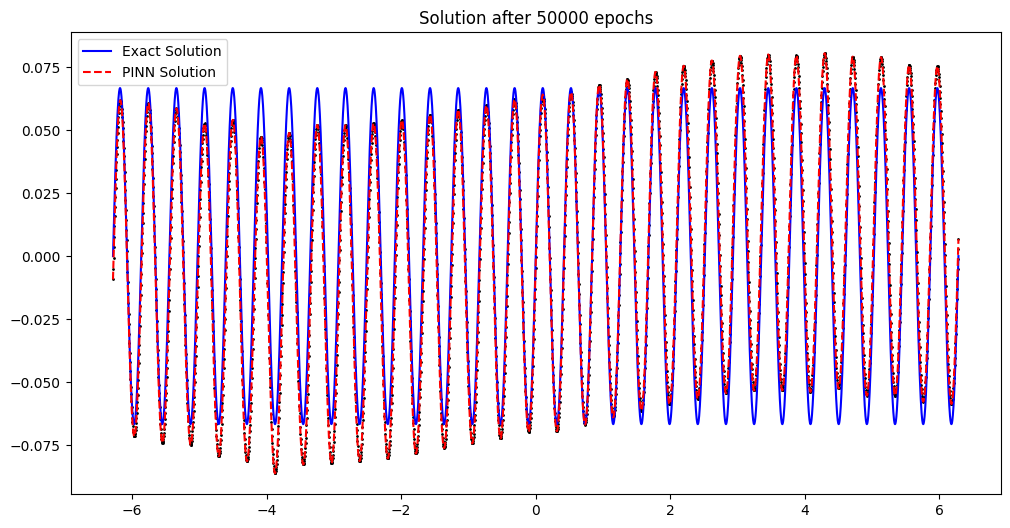

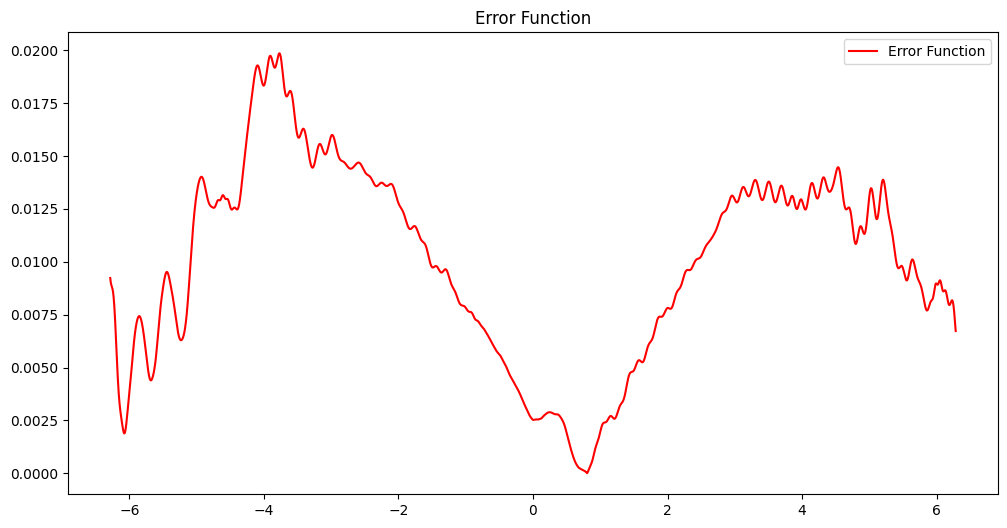

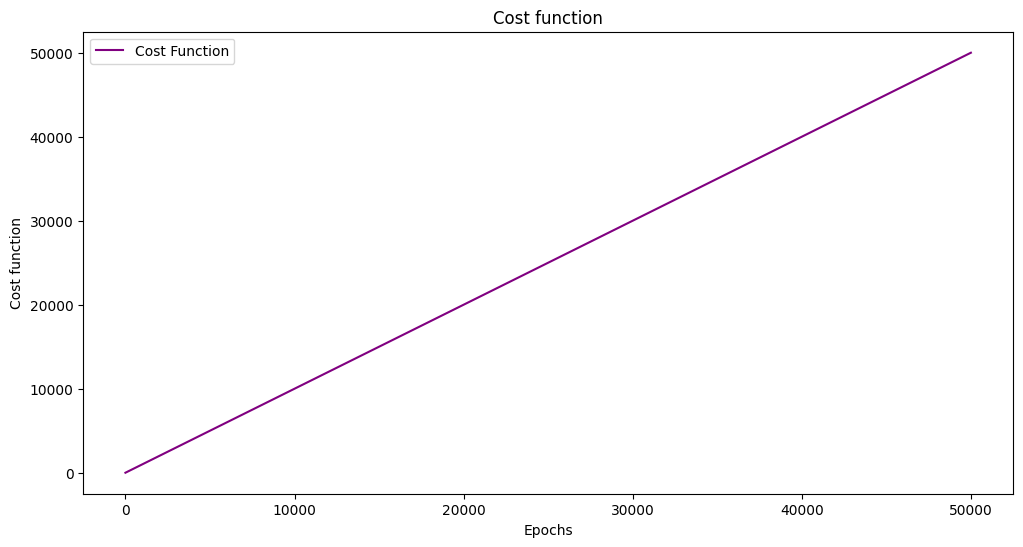

In [ ]:
plot_solution(model_test_b3, x_test_b, x_train_b, u_exact_b3, costs_b3, EPOCHS)

#### c)

##### ansatz cost

In [ ]:

# ansatz
def ansatz_residual_loss(model, x, omega):
    x = x.requires_grad_(True)
    u = torch.tanh(omega * x) * model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    residual = u_x - torch.cos(omega * x)
    return torch.mean(residual)

##### model - b3 parameters

In [ ]:
OMEGA = 15
TRAINING_POINTS = 3000
TESTING_POINTS = 5000

x_train_c = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

N_HIDDEN = 128
N_LAYERS = 5

model_c = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

In [ ]:
model_c, costs_c = train(model_b3, OMEGA, ansatz_residual_loss, EPOCHS, x_train_c, LR)

model_test_c = model_c

In [ ]:
torch.save(model_c, "model_c.pth")

##### testing

In [ ]:
x_test_c = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_c = exact_solution(x_test_c, OMEGA)

In [ ]:
model_test_c = torch.load("model_c.pth")

In [ ]:
plot_solution(model_test_c, x_test_c, x_train_c, u_exact_c, costs_c, EPOCHS)

#### d)

##### Fourier layer

In [ ]:
class Fourier(nn.Module):
    def __init__(self, input_dim, num_features):
        super(Fourier, self).__init__()
        tensor = torch.arange(input_dim // 2).repeat_interleave(2).unsqueeze(0)
        self.b = nn.Parameter(2** tensor * np.pi, requires_grad=True)
        
    def forward(self, x):
        x_proj = x * self.b
        result_matrix = torch.zeros_like(x_proj)
        for i in range(x_proj.size(0)):
            for j in range(x_proj.size(1)):
                if j % 2 == 0:
                    result_matrix[i][j] = torch.sin(x_proj[i][j])
                else:
                    result_matrix[i][j] = torch.cos(x_proj[i][j])
        return result_matrix           

##### model

In [ ]:
class FourierFCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            Fourier(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
OMEGA = 15
TRAINING_POINTS = 3000
TESTING_POINTS = 5000

x_train_d = torch.linspace(-2 * np.pi, 2 * np.pi, TRAINING_POINTS).view(-1, 1).requires_grad_(True)

In [ ]:
N_HIDDEN = 16
N_LAYERS = 2

model_d = FourierFCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)

In [ ]:
model_d, costs_d = train(model_d, OMEGA, total_loss, EPOCHS, x_train_d, LR)

model_test_d = model_d

NameError: name 'train' is not defined

In [ ]:
torch.save(model_d, "model_d.pth")

In [ ]:
x_test_d = torch.linspace(-2 * np.pi, 2 * np.pi, TESTING_POINTS).view(-1, 1)
u_exact_d = exact_solution(x_test_d, OMEGA)

In [ ]:
model_test_d = torch.load("model_d.pth")

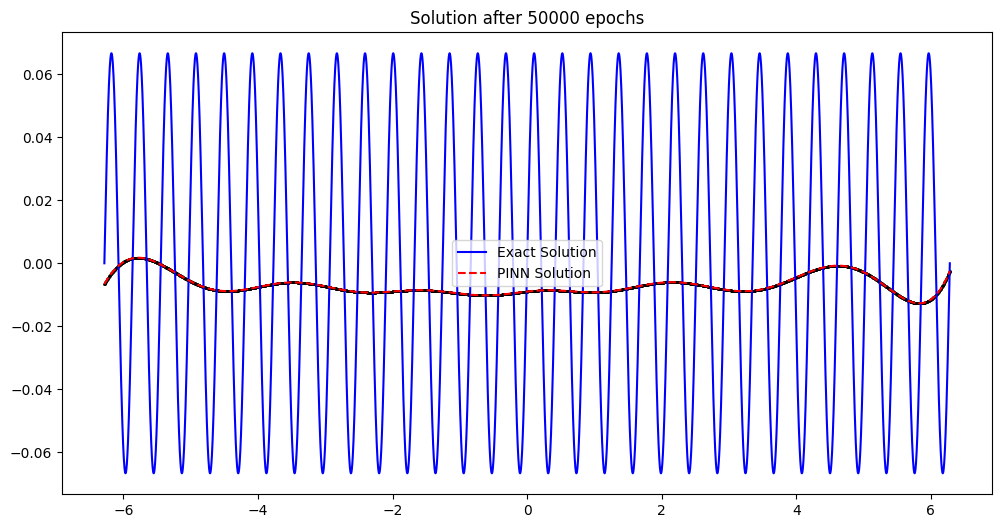

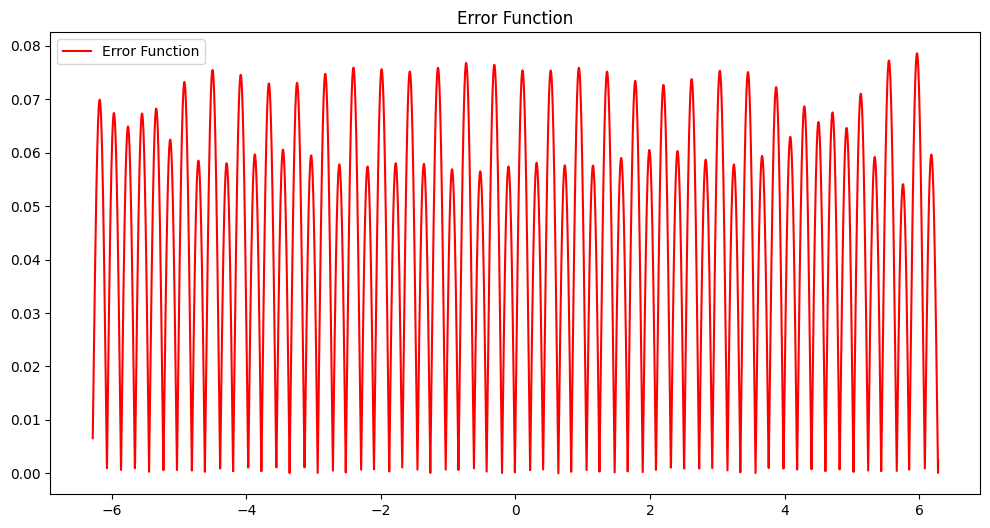

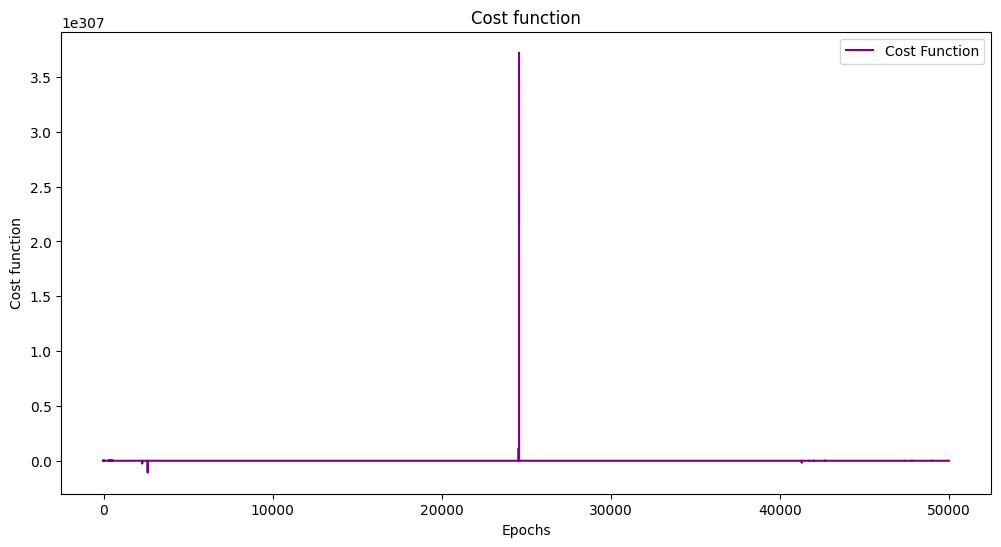

In [ ]:
plot_solution(model_test_d, x_test_d, x_train_d, u_exact_d, costs_d, EPOCHS)